In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install keras-vggface

In [ ]:
pip install Keras-Applications

     |████████████████████████████████| 51kB 7.1MB/s 


In [ ]:
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
class CyclicLR(Callback):
  def __init__(self, base_lr=0.0001, max_lr=0.001, step_size=5000., mode='triangular', gamma=1., scale_fn=None, scale_mode='cycle'):
    super(CyclicLR, self).__init__()
    self.base_lr = base_lr
    self.max_lr = max_lr
    self.step_size = step_size
    self.mode = mode
    self.gamma = gamma
    if scale_fn == None:
      if self.mode == 'triangular':
        self.scale_fn = lambda x: 1
        self.scale_mode = 'cycle'
      elif self.mode == 'triangular2':
        self.scale_fn = lambda x: 1/(2.**(x-1))
        self.scale_mode = 'cycle'
      elif self.mode == 'exp_range':
        self.scale_fn = lambda x: gamma**(x)
        self.scale_mode = 'iterations'
    else:
      self.scale_fn = scale_fn
      self.scale_mode = scale_mode
    self.clr_iterations = 0.
    self.trn_iterations = 0.
    self.history = {}

    self._reset()

  def _reset(self, new_base_lr=None, new_max_lr=None,new_step_size=None):
    if new_base_lr != None:
      self.base_lr = new_base_lr
    if new_max_lr != None:
      self.max_lr = new_max_lr
    if new_step_size != None:
      self.step_size = new_step_size
    self.clr_iterations = 0.

  def clr(self):
    cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
    x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
    if self.scale_mode == 'cycle':
      return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
    else:
      return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)

  
  def on_train_begin(self, logs={}):
    logs = logs or {}
    if self.clr_iterations == 0:
      K.set_value(self.model.optimizer.lr, self.base_lr)
    else:
      K.set_value(self.model.optimizer.lr, self.clr())

  def on_batch_end(self, epoch, logs=None):
    logs = logs or {}
    self.trn_iterations += 1
    self.clr_iterations += 1

    self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
    self.history.setdefault('iterations', []).append(self.trn_iterations)

    for k, v in logs.items():
      self.history.setdefault(k, []).append(v)
    
    K.set_value(self.model.optimizer.lr, self.clr())

In [ ]:
#Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace
import skimage
from skimage.transform import rescale, resize
#from clr_callback import *

In [ ]:
vgg_notop = VGGFace(model='resnet50', include_top=False, input_shape=(197, 197, 3), pooling='avg')
last_layer = vgg_notop.get_layer('avg_pool').output
x = layers.Flatten(name='flatten')(last_layer)
x = layers.Dropout(0.5)(x)
x = layers.Dense(4096, activation='relu', name='fc6')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu', name='fc7')(x)
x = layers.Dropout(0.5)(x)

In [ ]:
batch_norm_indices = [2, 6, 9, 13, 14, 18, 21, 24, 28, 31, 34, 38, 41, 45, 46, 53, 56, 60, 63, 66, 70, 73, 76, 80, 83, 87, 88, 92, 95, 98, 102, 105, 108, 112, 115, 118, 122, 125, 128, 132, 135, 138, 142, 145, 149, 150, 154, 157, 160, 164, 167, 170]
for i in range(170):
    if i not in batch_norm_indices:
        vgg_notop.layers[i].trainable = False

In [ ]:
out = layers.Dense(4, activation='softmax', name='classifier')(x)

model = models.Model(vgg_notop.input, out)

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001,
                            beta_1=0.9,
                            beta_2=0.999,
                            epsilon=1e-08,)

In [ ]:
rlrop = ReduceLROnPlateau(monitor='val_accuracy',mode='max',factor=0.5, patience=5, min_lr=0.00001, verbose=1)

In [ ]:
clr_triangular = CyclicLR(mode='triangular2')

In [ ]:
callback = EarlyStopping(monitor="val_accuracy", patience = 10, verbose = 1, mode="max")
check = ModelCheckpoint('/content/drive/My Drive/hh', monitor="val_accuracy", verbose = 1, save_best_only=True, mode="max")

In [ ]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(197, 197),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=128)

In [ ]:
! rm -rf train; mkdir train
! unzip -q /content/drive/MyDrive/train.zip -d train
! rm -rf dev; mkdir dev
! unzip -q /content/drive/MyDrive/test-public.zip -d dev
! rm -rf test; mkdir test
! unzip -q /content/drive/MyDrive/test-private.zip -d test

In [ ]:
train_generator  = get_datagen('/content/train', True)
dev_generator    = get_datagen('/content/dev')
test_generator  = get_datagen('/content/test')

Found 13005 images belonging to 4 classes.
Found 2622 images belonging to 4 classes.
Found 2590 images belonging to 4 classes.


In [ ]:
%%bash
root='train/'
IFS=$(echo -en "\n\b")
(for dir in $(ls -1 "$root")
    do printf "$dir: " && ls -i "$root$dir" | wc -l
 done)

0 angry: 2452
1 happy: 4459
2 sad: 3014
3 neutral: 3080


In [ ]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=dev_generator, 
    steps_per_epoch=13005// 128,
    validation_steps=2622 // 128,
    shuffle=True,
    epochs=30,
    callbacks=[clr_triangular, check]
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
101/101 [==============================] - 139s 1s/step - loss: 2.7221 - accuracy: 0.3432 - val_loss: 1.3893 - val_accuracy: 0.2461

Epoch 00001: val_accuracy improved from -inf to 0.24609, saving model to /content/drive/My Drive/hh
INFO:tensorflow:Assets written to: /content/drive/My Drive/hh/assets
Epoch 2/30
101/101 [==============================] - 134s 1s/step - loss: 1.2218 - accuracy: 0.4945 - val_loss: 1.3847 - val_accuracy: 0.2309

Epoch 00002: val_accuracy did not improve from 0.24609
Epoch 3/30
101/101 [==============================] - 134s 1s/step - loss: 1.0234 - accuracy: 0.5691 - val_loss: 1.4066 - val_accuracy: 0.2313

Epoch 00003: val_accuracy did not improve from 0.24609
Epoch 4/30
101/101 [==============================] - 134s 1s/step - loss: 0.9237 - accuracy: 0.6181 - val_loss: 1.4437 - val_accuracy: 0.2328

Epoch 00004: val_accuracy did not improve from 0.24609
Epoch 5/30
101/101 [==============================] - 133s 1s/step - loss: 0.8675 - accura

In [ ]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(test_generator, 2590 // 128)
print('test loss, test acc:', results_test)


# Evaluate on test data


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test loss, test acc: [0.6247631311416626, 0.760937511920929]


In [ ]:
model.save('/content/drive/My Drive/resnet50-vggface-4class_acc_triangle2 v2.h5')

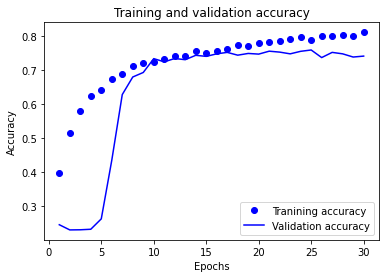

In [ ]:
#Plot accuracy
def plot_acc():
    
    plt.clf()

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']


    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, 'bo', label='Tranining accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
plot_acc()

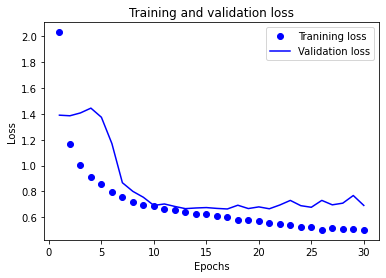

In [ ]:
#Plot loss
def plot_loss():
    
    plt.clf()
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(loss) + 1)
    
    plt.plot(epochs, loss, 'bo', label='Tranining loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_loss()

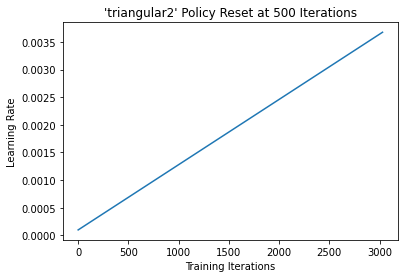

In [ ]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("'triangular2' Policy Reset at 500 Iterations")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])